$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 7: Attention

## Introduction

In this tutorial, we will cover:

- Attention mechanisms
- Sequence to sequence models for machine translation
- Implementing attention
- Using attention for alignment during translation

In [46]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import tqdm
import torch
import matplotlib.pyplot as plt

In [47]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Theory reminders

### RNNs

In the context of learning from **sequences** of inputs, we have seen RNNs as a model capable of learning a transformation of one sequence into another.

A two-layer basic RNN:

<center><img src="img/rnn_layered.png" width="900" /></center>

Where, for each layer $l\geq 0$ (layer zero is the input) and "time" $t > 0$, a vanilla RNN is defined by:

$$
\begin{align}
\vec{h}_t^l &= \varphi_1\left( \mat{W}_{hh}^l \vec{h}_{t-1}^l + \mat{W}_{xh}^l \vec{x}_t^{l-1} + \vec{b}_h^l\right) \\
\vec{x}_t^l &= \varphi_2\left(\mat{W}_{hy}^l\vec{h}_t^l + \vec{b}_x^l \right).
\end{align}
$$

Over time "fancy" versions of RNNs became popular, mainly LSTMs and more recently **GRU**s:

<center><img src="img/GRU.png" width=900 /></center>

The main idea is to have "soft-gates" ($\vec{r}_t$ and $\vec{z}_t$) that control how much of the previous state ($\vec{h}_{t-1}$) affects the next state $\vec{h}_t$ relative to the proposed next state $\tilde{\vec{h}}_{t}$.

In practice these model can be trained more effectively on longer sequences and therefore can model longer dependencies compared to vanilla RNNs.

However, RNNs (even the fancy ones) still generally have some major drawbacks:

1. Input must be processed sequentially.
2. Hard to train on long sequences (needs BPTT). LSTMs and GRUs don't suffer from vanishing gradients, but gradients explode.
3. Difficult to learn long-term dependencies, e.g. between late outputs and early inputs. The **hidden state** has the burden of "remembering" the "meaning" of the entire sequence so far.

### Encoder-decoder architectures

A common architecture used in many tasks is the encoder-decoder pattern.

- The **encoder** maps the input to some latent representation, usually of a low dimension.
- The **decoder** applies a different mapping, from the latent space to some other space (sometimes back to the input space).

<center><img src="img/enc_dec.png" width=700 /></center>

Some common use cases are e.g.
- Nonlinear dimentionality reduction: Autoencoders
- Generative models: VAEs
- Machine translation: Seq2Seq models

### Attention

In deep learning contexts, **attention** is a term used for a family of related mechanisms which, in general, learn to predict some probability distribution over a sequence of elements.

Intuitively, this allows a model to "pay more attention" to elements from the sequence which get a higher probability.

Recent versions of attention mechanisms can be defined formally as follows:

Given:
- $n$ **key-value** pairs: $\left\{\left(\vec{k}_i, \vec{v}_i\right)\right\}_{i=1}^{n}$, where $\vec{k}_i\in\set{R}^{d_k}$, $\vec{v}_i\in\set{R}^{d_v}$
- A **query**, $\vec{q} \in\set{R}^{d_q}$
- Some similarity (sometimes called *energy*) function between keys and queries, $e: \set{R}^{d_k}\times \set{R}^{d_q} \mapsto \set{R}$

A *soft*-attention mechanism computes a weighted sum of the **values**,

$$
\vec{o} = \sum_{i=1}^{n} a_i \vec{v}_i\ \in \set{R}^{d_v},
$$

where attention weights $a_i$ are computed according the the similarity between the **query** and each **key**:

$$
\begin{align}
b_i &= e(\vec{k}_i, \vec{q}) \\
\vec{b} &= \left[  b_1, \dots, b_n \right]\Tr \\
\vec{a} &= \softmax{\vec{b}}.
\end{align}
$$


It's also possible to define *hard*-attention by using the weights $\vec{a}$ as a discrete distribution over the values, and sample a single $\vec{v}_i$ from this distribution:

$$
\vec{o} \sim \mathrm{Multinoulli}\left(\vec{a}; \left\{\vec{v}_i\right\}_{i=1}^{n}\right)
$$

In this case the attention output is stochastic.

A famous example of attention from an image-captioning paper ([Xu et al. 2015](http://proceedings.mlr.press/v37/xuc15.pdf)):
<center><img src="img/xu2015_1.png" width="1100" /></center>

Core ideas of this model:
- Use pre-trained CNN  to extract `14x14` 512-dimensional convolutional feature maps from an image: "location annotations"
- Train LSTM to generate image caption word by word
- Learn to apply attention to the annotations (keys/values) based on LSTM hidden state (query)
- Include the attention-weighted annotations in the next hidden state

<center><img src="img/xu2015_2.png" width="800"/></center>

### Multiplicative attention

One basic type of attention mechanism uses a simple **dot product** as the similarity function.

Widely-used by models based on the **Transformer** architecture.

Assume $d_k=d_q=d$, then

$$
e(\vec{k},\vec{q})= \frac{\vectr{k}\vec{q}}{\sqrt{d}}.
$$

Why scale by $\sqrt{d}$ ?

It's the factor at which the dot-product grows due to the dimensionality. E.g.,

$$
\norm{\vec{1}_d}_2 = \norm{[1,\dots,1]\Tr}_2 = \sqrt{d\cdot 1^2} =\sqrt{d}.
$$

This helps keep the softmax values from becoming very small when the dimension is large, and therefore helps prevent tiny gradients.

Let's now deal with $m$ queries simultaneously by stacking them in a matrix $\mat{Q} \in \set{R}^{m\times d}$.

Similarly, we'll stack the keys and values in their own matrices, $\mat{K}\in\set{R}^{n\times d}$, $\mat{V}\in\set{R}^{n\times d_v}$.

Then we can compute the attention weights for all queries in parallel:

$$
\begin{align}
\mat{B} &= \frac{1}{\sqrt{d}} \mat{Q}\mattr{K}  \ \in\set{R}^{m\times n} \\
\mat{A} &= \softmax{\mat{B}},\ \mathrm{dim}=1 \\
\mat{O} &= \mat{A}\mat{V} \ \in\set{R}^{m\times d_v}.
\end{align}
$$

Note that the softmax is applied per-row, and so each row $i$ of $\mat{A}$ contains the attention weights for the $i$th query.

Also notice that in this formulation, we **input a sequence** of $m$ queries and get an **output sequence** of $m$ weighed values.

### Additive attention

Another common type of attention mechanism uses an MLP to **learn** the similarity function $s(\vec{k},\vec{q})$.

In this type of attention, the similarity function is 

$$
e(\vec{k},\vec{q}) = \vectr{v} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{v}\in\set{R}^{h}$ are trainable parameters.

- Notice that we're adding projected versions of the key and query and applying a 2-layer MLP.
- Both projections and the output layer are trainable.

### Self-Attention

Self-attention refers to applying attention on a **single sequence**  $\left\{\vec{x}_i\right\}_{i=1}^{n}$ of elements.

The keys, values and queries are either:
- The elements themselves
- Computed from them with **learned** linear projections, i.e.
$$
\begin{align*}
\vec{q}_{i} &= \mat{W}_{xq}\vec{x}_{i} &
\vec{k}_{i} &= \mat{W}_{xk}\vec{x}_{i} &
\vec{v}_{i} &= \mat{W}_{xv}\vec{x}_{i} 
\end{align*}
$$
This is what Transformer models do for Seq2Seq, instead of using RNNs.

For example, the following image depicts multiplicative self-attention transforming the sequence $\left\{\vec{x}_i\right\}_{i=1}^{n}$ into the sequence $\left\{\vec{y}_i\right\}_{i=1}^{n}$.

<center><img src="img/self_attn_transformer.svg" width=600></center>

## Part 1: Sequence-to-Sequence Machine Translation

In this part we'll translate text from German to English.

The general approach using RNNs is to design a Sequence-to-sequence (**Seq2Seq**) Encoder-Decoder architecture:

<center><img src="img/seq2seq1.png" width="900" /></center>

- The encoder processes the source sequence
- The final encoder hidden state represents the entire source sequence
- This representation is passed to the decoder as it's initial hidden state
- During training the decoder is fed with the target sequence
- Both parts are trained together, end to end

We'll implement this idea roughly based on [Sutskever et al. (2014)](https://arxiv.org/abs/1409.3215).

BTW, is this encoder-decoder model also a **Generative** model?

I.e., can we use this model, once trained, to generate coherent sentences in English?

Theoretically we could... If we could somehow engineer the initial context vector that has a meaning.
But how can we sample such an input context vector?

In practice, without enforcing some kind of constraints on $z$, we can't.

### Dataset

We'll use the [Multi30K](https://www.statmt.org/wmt16/multimodal-task.html) Multimodal Dataset, which contains 30K images and sentences describing them in both German and English. We'll only use the textual data.

The `torchtext` package provides us with a convenient way to load our dataset.

In [89]:
from torchtext.datasets import Multi30k
from torchtext.data import Field

# Common args for field objects
field_args = dict(tokenize='spacy',
                  init_token='<sos>',
                  eos_token='<eos>',
                  include_lengths=True,
                  lower=True) 

# Field for processing German source
src_field = Field(tokenizer_language="de_core_news_sm", **field_args)

# Field for processing English target
tgt_field = Field(tokenizer_language="en_core_web_sm", **field_args)

In [90]:
ds_train, ds_valid, ds_test = Multi30k.splits(
    root=data_dir, exts=('.de', '.en'), fields=(src_field, tgt_field)
)

VOCAB_MIN_FREQ = 2 # ignore very rare words to decrease vocab size
src_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)
tgt_field.build_vocab(ds_train, min_freq=VOCAB_MIN_FREQ)

In [91]:
print('#train samples: ', len(ds_train))
print('#valid samples: ', len(ds_valid))
print('#test  samples: ', len(ds_test))

#train samples:  29000
#valid samples:  1014
#test  samples:  1000


In [92]:
V_src = len(src_field.vocab)
print(f'source vocab size: {V_src}')

V_tgt = len(tgt_field.vocab)
print(f'target vocab size: {V_tgt}')

source vocab size: 7855
target vocab size: 5893


Let's print a few random samples from the dataset:

In [93]:
import random
for _ in range(5):
    i = random.randrange(len(ds_train))
    example = ds_train[i]
    src = str.join(" ", example.src)
    tgt = str.join(" ", example.trg)
    print(f'sample#{i:05d}:\n\tDE: {src}\n\tEN: {tgt}')

sample#26597:
	DE: ein mann in einem gestreiften oberteil , mit weste , krawatte und hut schenkt sich bowle auf einer großen schüssel ein .
	EN: a man in a striped shirt , vest , tie , and hat is serving himself punch from a large bowl .
sample#24399:
	DE: ein junge in schwarz winkt mit den armen , während sich andere menschen hinter ihm auf einem feld aufhalten .
	EN: a boy in black waves his arms while other people are behind him on a field .
sample#18896:
	DE: schüler verbringen ihre pausen im freien und genießen die gesellschaft der anderen .
	EN: student spend their breaks outside enjoying each others company .
sample#21597:
	DE: zwei männer sitzen auf einer bank , wobei einer der männer seinen kopf in seinen schoß gelegt und einen großen gelben sack neben sich stehen hat .
	EN: two men sitting on a bench where one has his head in his lap and a large yellow bag next to him .
sample#07312:
	DE: drei kinder skaten auf einer rollschuhbahn .
	EN: three children are skating on a roller

Remember that we're using a **tokenizer** which assigned a number to each token (~=word), and creates some **special tokens**:

In [94]:
topn = 30
print(f'DE top{topn}: {src_field.vocab.itos[0:topn]}\n')
print(f'EN top{topn}: {tgt_field.vocab.itos[0:topn]}\n')

DE top30: ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',', 'und', 'mit', 'auf', 'mann', 'einer', 'der', 'frau', 'die', 'zwei', 'einen', 'im', 'an', 'von', 'sich', 'dem', 'mädchen', 'junge', 'vor', 'zu', 'steht']

EN top30: ['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'woman', ',', 'two', 'are', 'to', 'people', 'at', 'an', 'wearing', 'shirt', 'young', 'white', 'black', 'his', 'while', 'blue']



In [95]:
UNK_TOKEN = tgt_field.vocab.stoi['<unk>']
PAD_TOKEN = tgt_field.vocab.stoi['<pad>']

print(f'<unk>={UNK_TOKEN}, <pad>={PAD_TOKEN}')

<unk>=0, <pad>=1


Let's create a data loader and look at the generated batches.

In [96]:
from torchtext.data import BucketIterator

BATCH_SIZE = 4
dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size = BATCH_SIZE)

In [97]:
# dataloader returns a Batch object with .src and .trg attributes
b0 = next(iter(dl_train))

# The .src/.trg attributes contain tuples of sequences and their lengths
# Get batches of sequences 
x0, x0_len = b0.src
y0, y0_len =  b0.trg

print('x0 (S1, B):\n', x0, x0.shape)
print('x0_len (B,):\n', x0_len, x0_len.shape)
print('y0 (S2, B)):\n', y0, y0.shape)
print('y0_len: (B,)\n', y0_len, y0_len.shape)

x0 (S1, B):
 tensor([[   2,    2,    2,    2],
        [  18,    5,    8,    8],
        [  65,   13,   16,   16],
        [   9,   68,   37,   11],
        [  44,    8,   19,   14],
        [ 271,    0,  870,   71],
        [   9,  254,   10,   89],
        [  44,   63,  134,   31],
        [ 173,    9,  722,   10],
        [ 358, 7432,    7,   38],
        [   9,   84,   81, 1186],
        [3786,   20,   10,    4],
        [1291,   86,  464,    3],
        [  19,   28,  100,    1],
        [ 356,  144,  690,    1],
        [ 273,    4, 2753,    1],
        [ 937,    3,   28,    1],
        [   4,    1,  187,    1],
        [   3,    1,    4,    1],
        [   1,    1,    3,    1]]) torch.Size([20, 4])
x0_len (B,):
 tensor([19, 17, 20, 13]) torch.Size([4])
y0 (S2, B)):
 tensor([[   2,    2,    2,    2],
        [  16,    4,    4,    4],
        [  63,    9,   14,   14],
        [  15,   10,   10,   13],
        [  46,  169,   45,    4],
        [   6,    4,  517,   26],
        [  31

### Model

Our *encoder* needs to be very simple. 
- Embed each source-language token in the sequence into a dense vector representation
- Feed the sequence through an RNN (we'll use a multilayer GRU)
- Output the final hidden states from each layer

Note that we also return the intermediate hidden stated from the last layer. We'll need these later.

In [98]:
import torch.nn as nn

class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Encoder has no output layer; we just return hidden states.
        
    def forward(self, x, **kw):
        # x shape: (S, B) Note batch dim is not first!
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # GRU first  output: all hidden states from last layer (S, B, H)
        # GRU second output: last hidden state from each layer (L, B, H)
        h, ht = self.rnn(embedded)
        return h, ht

Test the encoder with a batch of German sentences:

In [99]:
EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
h, ht = enc(x0)
print(f'h (S1, B, H): {h.shape}')
print(f'ht (L, B, H): {ht.shape}')

h (S1, B, H): torch.Size([20, 4, 64])
ht (L, B, H): torch.Size([2, 4, 64])


Now the *decoder*. We need to:
- Embed target-language tokens
- Apply RNN to the sequence, with initial hidden state from encoder
- Output is projection of intermediate hidden states from last layer to target-language tokens

In [100]:
class Seq2SeqDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        
        # nn.Embedding converts from token index to dense tensor
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # PyTorch multilayer GRU RNN
        self.rnn = nn.GRU(embedding_dim, h_dim, num_layers=num_layers, dropout=dropout)
        
        # Output layer, note the output dimension!
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, context, **kw):
        # x shape: (S, B)
        # context: (L, B, H) the last hidden state from the encoder
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Note initial hidden state is the input context vector
        # h:  all hidden states from last layer (S, B, H)
        # ht: last hidden state from each layer (L, B, H)
        h, ht = self.rnn(embedded, context)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

Test the decoder with the corresponding batch of English sentences:

In [101]:
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
yhat, _ = dec(y0, ht) # note different S
print(f'yhat (S2, B, V_tgt): {yhat.shape}')

yhat (S2, B, V_tgt): torch.Size([23, 4, 5893])


Next, we'll implement a `Seq2Seq` class to handle the combined forward pass through both the encoder and decoder.

During the forward pass, we'll take a source and target sequence and:
- Forward the source sequence through the encoder, obtaining the final hidden state.
- For the decoder, we'll either do:
    - Teacher forcing: Feed the decoder tokens from the target sequence one by one.
    - Greedy prediction: Use the decoder's output to predict the most likely next token, and feed it.

Teacher forcing:
<center><img src="img/seq2seq.svg" width="900"></center>

Greedy prediction:
<center><img src="img/seq2seq_predict.svg" width="900"></center>

Note that obviously in both cases the target sequence is still used to compute the loss.

Teacher forcing can speed up training, but it can hurt generalization. We'll take a probabilistic approach:
- Use teacher forcing with some probability $p_\mathrm{tf}$.
- Start $p_\mathrm{tf}$ high and decrease each epoch.
- When evaluating, set $p_\mathrm{tf}=0$.

In [102]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Seq2SeqEncoder, decoder: Seq2SeqDecoder):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
    
    def forward(self, x_src, x_tgt, p_tf=0, **kw):
        # input shapes: (S1, B), (S2, B)
        # p_tf: probaility of teacher-forcing decoder input. Zero means greedy-search prediction.
        S2, B = x_tgt.shape
        
        # Forward pass through encoder
        # context is (L, B, H)
        enc_h, context = self.enc(x_src, **kw)
        
        # First input is first target token
        dec_input = x_tgt[[0], :] # (1, B)
        # Loop over tokens in target sequence and feed them to the decoder
        dec_outputs = []
        for t in range(1, S2):
            # Feed the decoder sequences of length 1 & save new context
            dec_output, context = self.dec(dec_input, context, enc_h=enc_h, **kw) # dec_output is (1, B, V)
            dec_outputs.append(dec_output)
            
            # For next input, take either:
            # - next target token (AKA "teacher forcing"), with proba p_tf
            # - highest scoring output (greedy prediction of next token), with proba 1-p_tf
            if p_tf > torch.rand(1).item():
                dec_input = x_tgt[[t], :] # (1, B)
            else:
                dec_input = torch.argmax(dec_output, dim=2) # (1,B,V) -> (1, B)
            
        # Stack decoder outputs from all timesteps
        y_hat = torch.cat(dec_outputs, dim=0) # (S-1)x(1,B,V) -> (S-1,B,V)
        
        # Output shape: (S-1, B, V)
        return y_hat

Test the `Seq2Seq` model:

In [103]:
seq2seq_model = Seq2Seq(enc, dec)
yhat = seq2seq_model(x0, y0)
print('y_hat (S-1, B, V_tgt):', yhat.shape)

y_hat (S-1, B, V_tgt): torch.Size([22, 4, 5893])


### Training and evaluation

The training logic is fairly standard, with only a few nuances:
- Notice that the output sequence is shorter than the ground truth due to the `<sos>` token
- Clip gradient norm to prevent exploding grads
- When computing the loss, we'll use Cross Entropy, but ignore the `<pad>` tokens

The following code trains the model for a **single epoch**:

In [104]:
def train_seq2seq(model, dl_train, optimizer, loss_fn, p_tf=1., clip_grad=1., max_batches=None):
    losses = []
    with tqdm.tqdm(total=(max_batches if max_batches else len(dl_train)), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_train, start=1):
            x, x_len = batch.src
            y, y_len =  batch.trg

            # Forward pass: encoder and decoder
            # Output y_hat is the translated sequence
            y_hat = model(x, y, p_tf, src_len=x_len)
            S, B, V = y_hat.shape

            # y[:,i] is <sos>, w_1, w_2, ..., w_k, <eos>, <pad>, ...
            # y_hat is   w_1', w_2', ..., w_k', <eos>', <pad>', ...
            # based on the above, get ground truth y
            y_gt = y[1:, :].reshape(S*B)  # drop <sos>
            y_hat = y_hat.reshape(S*B, V)

            # Calculate loss compared to ground truth y
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y_gt)
            loss.backward()

            # Prevent exploding gradients
            if clip_grad > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            # Update parameters
            optimizer.step()

            losses.append(loss.item())
            pbar.update(); pbar.set_description(f'train loss={losses[-1]:.3f}')
            if max_batches and idx_batch >= max_batches:
                break
    return losses

In evaluation mode, we do roughly the same, but make sure to not use teacher forcing.

Note that in the context of machine translation, usually a different accuracy metric is used (BLEU score), instead of simple token-based accuracy. Here we just use a function from the `nltk` package to calculate it, as an example.

In [105]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

def eval_seq2seq(model, dl_test):
    accuracies = []
    bleus = []
    with tqdm.tqdm(total=len(dl_test), file=sys.stdout) as pbar:
        for idx_batch, batch in enumerate(dl_test):
            x, x_len = batch.src
            y, y_len =  batch.trg

            with torch.no_grad():
                y_hat = model(x, y, p_tf=0, src_len=x_len)  # Note: no teacher forcing in eval

            S, B, V = y_hat.shape

            y_gt = y[1:, :] # drop <sos>
            y_hat = torch.argmax(y_hat, dim=2) # greedy-sample -> (S,B)

            # Compare prediction to ground truth
            accuracies.append(torch.sum(y_gt == y_hat) / S)
            bleus.append(np.mean([
                sentence_bleu([y_gt[:, i]], y_hat[:, i]) for i in range(B)
            ]))

            pbar.update(); pbar.set_description(f'eval acc={accuracies[-1]}')
    return accuracies, bleus

Lets run training on a small model for a few epochs, just to see if it works.

In [106]:
BATCH_SIZE = 128
# Use small model so that training is fast, just an example
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 3
GRAD_CLIP = 1.
EPOCHS = 2
BATCHES_PER_EPOCH=25

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
dec = Seq2SeqDecoder(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
seq2seq_model = Seq2Seq(enc, dec)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing for the first 20 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    accuracies += eval_seq2seq(seq2seq_model, dl_valid)[0]

=== EPOCH 1/2, p_tf=1.00 ===
eval acc=9: 100%|██████████| 8/8 [00:02<00:00,  3.70it/s] 
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=10: 100%|██████████| 8/8 [00:02<00:00,  3.85it/s]


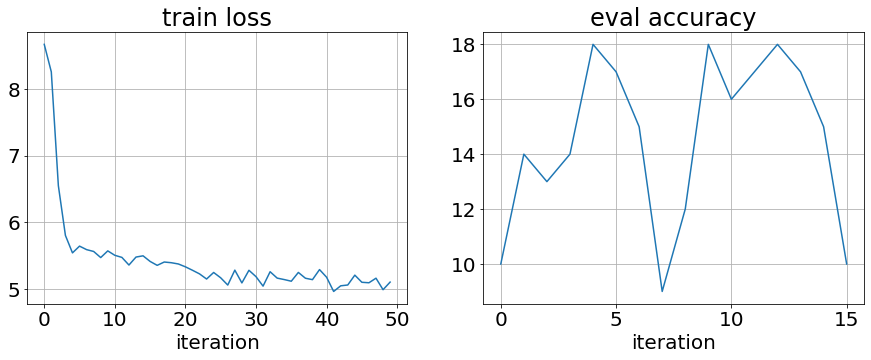

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)

Now we just need to train for a few days on multiple GPUs to get descent results :)

What information is captured by the final encoder hidden state when we train such a model end-to-end?

Intuitively, we expect it to contain the "meaning" of the entire sentence, so that the decoder can translate it.

Sutskever et al. demonstrate this by applying a 2D PCA to the last encoder hidden state:

<center><img src="img/sutskever2014_pca.png", width="1000"></center>

We can see that sentences with similar meanings appear to be clustered together, i.e. they have a similar representation.

What is the major limitation of this approach though?

Limitation: In this architecture the encoder's last hidden state must encode all the information the decoder needs for translation. It must represent the entire meaning of the source sentence.

Local information, i.e. the encoder outputs and intermediate hidden states is discarded.

Can we somehow use this local info to help the decoder?

## Part 2: Using Attention for Alignment

Now we'll add attention to our model in order to use the encoder's intermediate information. This will allow our decoder to **focus** on different parts of the **source** sequence while it's generating the target sequence.

The approach here is based on the classic paper "Neural Machine Translation by Jointly Learning to Align and Translate" by [Bahdanau et al.](http://arxiv.org/abs/1409.0473) (ICLR, 2015).

How should we use attention to allow the decoder to focus on different parts on the input?

- We'll treat the encoder's outputs (last layer's hidden states) as both keys and values.
- We'll use the decoder's hidden state as a query at each time step.
- The attention output will therefore be a weighed average of the encoder outputs most matching the current decoder state.
- The output will be treated as a **context**, and concatenated to the decoder input in the next time step.

<center><img src="img/seq2seq_attention.svg" width=1000></center>

Note that with this approach, the encoder's last hidden state no longer needs to convey the entire meaning because decoder can look at different parts of the source sequence.

### Implementing Attention

To start, lets first implement an additive attention block using a 2-layer MLP.

As we saw previously, in this type of attention the similarity ("energy") function is 

$$
e(\vec{k},\vec{q}) = \vectr{v} \tanh(\mat{W}_k\vec{k} + \mat{W}_q\vec{q}),
$$

where $\mat{W}_k\in\set{R}^{h\times d_k}$, $\mat{W}_q\in\set{R}^{h\times d_q}$ and $\vec{v}\in\set{R}^{h}$ are trainable parameters.

An important detail is that since we're using the encoder outputs as key/values, and some outputs correspond to `<pad>` tokens, we need a way to tell our attention block to ignore these outputs (give them zero attention weight).

We'll add a `seq_len` argument to our attention which should specify the length of the sequence without padding.

In [124]:
from torch import Tensor
class MLPAttention(nn.Module):
    def __init__(self, q_dim, k_dim, v_dim, h_dim):
        super().__init__()
        self.wk = nn.Linear(k_dim, h_dim, bias=False)
        self.wq = nn.Linear(q_dim, h_dim, bias=False)
        self.v  = nn.Linear(h_dim, 1, bias=False)
        
    def forward(self, q: Tensor, k: Tensor, v: Tensor, seq_len: Tensor=None):
        # q: Queries tensor of shape (B, Q, q_dim)
        # k: Keys tensor of shape (B, K, k_dim)
        # v: Values tensor of shape (B, K, v_dim)
        # seq_len: Sequence lengths tensor of shape (B,). Specifies how many key/values to use in each example.
        
        # Project keys to hidden dimension
        # (B, K, k_dim) -> (B, K, h_dim) -> (B, 1, K, h_dim)
        wk_k = self.wk(k).unsqueeze(1)
        
        # Project queries to hidden dimension
        # (B, Q, q_dim)  -> (B, Q, h_dim)  -> (B, Q, 1, h_dim)
        wq_q = self.wq(q).unsqueeze(2)
        
        # First layer of MLP: Use broadcast-addition to combine, then apply nonlinearity
        # (B, Q, K, h_dim)
        z1 = torch.tanh(wq_q + wk_k)
        
        # Second layer of MLP
        # (B, Q, K, 1) -> (B, Q, K)
        z2 = self.v(z1).squeeze(dim=-1)
        
        # Mask z2 before applying softmax: only seq_len keys are non-padding in each of the B samples
        if seq_len is not None:
            B, Q, K = z2.shape
            idx = torch.arange(K).expand_as(z2)    # (B,Q,K) containing indices 0..K-1
            mask = idx >= seq_len.reshape(B, 1, 1) # mask selects indices greater than seq_len
            z2[mask] = float('-inf')               # set selected to -inf to prevent influence on softmax
        
        # Apply softmax on last dimension to get attention weights, per query
        a = torch.softmax(z2, dim=-1)
        
        # Apply the attention weights to the values, per query
        # (B, Q, K) * (B, K, v_dim) -> (B, Q, v_dim)
        return torch.bmm(a, v)

To test the attention block, lets create some simple queries and key-value pairs.

In [109]:
# Create one query of dim 3 (but in a batch of 2)
q = torch.ones((2, 1, 3), dtype=torch.float)
print('q (B, Q, q_dim):\n', q)

q (B, Q, q_dim):
 tensor([[[1., 1., 1.]],

        [[1., 1., 1.]]])


In [111]:
# Create 4 key-value pairs
k = torch.ones(2, 4, 2, dtype=torch.float)
print('k (B, K, k_dim):\n', k)
v = torch.arange(40, dtype=torch.float).reshape(2, 5, 4).transpose(1, 2)
print('v (B, K, v_dim):\n', v)

k (B, K, k_dim):
 tensor([[[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]])
v (B, K, v_dim):
 tensor([[[ 0.,  4.,  8., 12., 16.],
         [ 1.,  5.,  9., 13., 17.],
         [ 2.,  6., 10., 14., 18.],
         [ 3.,  7., 11., 15., 19.]],

        [[20., 24., 28., 32., 36.],
         [21., 25., 29., 33., 37.],
         [22., 26., 30., 34., 38.],
         [23., 27., 31., 35., 39.]]])


In [112]:
attn = MLPAttention(q_dim=3, k_dim=2, v_dim=5, h_dim=100)

In [113]:
o = attn(q, k, v, seq_len=None)
print(o)
print(f'(B, Q, v_dim) = {o.shape}')

tensor([[[ 1.5000,  5.5000,  9.5000, 13.5000, 17.5000]],

        [[21.5000, 25.5000, 29.5000, 33.5000, 37.5000]]],
       grad_fn=<BmmBackward>)
(B, Q, v_dim) = torch.Size([2, 1, 5])


Output is a sequence of length 1 because we had one query.

Notice that the result is an average of the values, since all keys are equally similar to the query.

Let's try with `seq_len=1`, i.e. only the first token in the input is considered valid (not padding):

In [27]:
attn(q, k, v, seq_len=torch.tensor([1, 1]))

tensor([[[ 0.,  4.,  8., 12., 16.]],

        [[20., 24., 28., 32., 36.]]], grad_fn=<BmmBackward>)

Since `seq_len=1`, the output exactly equals the first value `v[:,0,:]` since only it received nonzero attention.

Now lets use `seq_len` to take the first two values in the first example, and all values in the second example.

In [115]:
attn(q, k, v, seq_len=torch.tensor([2, 4]))

tensor([[[ 0.5000,  4.5000,  8.5000, 12.5000, 16.5000]],

        [[21.5000, 25.5000, 29.5000, 33.5000, 37.5000]]],
       grad_fn=<BmmBackward>)

We can see the first result is the average of the first two values, and the second result is the average of all four.

### Updating the Model

Now we're ready to add the attention block to our model.

To do this, we only need to modify our `Seq2SeqDecoder` class. The rest can stay the same.

The decoder's `forward` method now needs to also receive all the encoder outputs (`enc_h`) and the length (without padding) of the source sequence (`src_len`).

In [118]:
class Seq2SeqDecoderAttn(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, h_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # The Q, K, V dims are all h_dim because of how we parametrized encoder and decoder
        self.attn = MLPAttention(h_dim, h_dim, h_dim, h_dim)
        
        # Note: GRU input dim now includes both embedding and attention output!
        self.rnn = nn.GRU(embedding_dim + h_dim*num_layers, h_dim, num_layers=num_layers, dropout=dropout)
        
        self.out_fc = nn.Linear(h_dim, vocab_size)
        
    def forward(self, x, h_prev, enc_h, src_len, **kw):
        # x shape: (S, B)
        # h_prev: (L, B, H) the initial/previous hidden state
        # enc_h: (S, B, H) all outputs from encoder (key-values for attention)
        # src_len: (B,) the length without padding of the encoder's sequence
        S, B = x.shape
        embedded = self.embedding(x) # embedded shape: (S, B, E)
        
        # Apply attention: Query is prev hidden state; key/vals are enc outputs without positions of padding
        q  = h_prev.transpose(0, 1)    # (B, L, H)
        kv = enc_h.transpose(0, 1) # (B, S, H)
        a  = self.attn(q, kv, kv, seq_len=src_len)  # (B, L, H)
        
        # Create RNN input by concatenating attention-based context with the embedded inputs
        # Note that when used with Seq2Seq we have S=1 so the expand is not needed
        # (L, B, H) -> (1, B, L*H) -> (S, B, L*H)
        a = a.reshape(1, B, -1).expand(S, -1, -1)
        rnn_input = torch.cat((embedded, a), dim=2) # (S, B, E + L*H)
        
        h, ht = self.rnn(rnn_input, h_prev)
        
        # Project H back to the vocab size V, to get a score per word
        out = self.out_fc(h)
        
        # Out shapes: (S, B, V) and (L, B, H)
        return out, ht

To train, we can use the exact same code we used before. Just need to change the decoder part of the moedl.

In [122]:
BATCH_SIZE = 128
# Use small model so that training is fast, just an example
EMB_DIM = 64
HID_DIM = 128
NUM_LAYERS = 3
GRAD_CLIP = 1.
EPOCHS = 2
BATCHES_PER_EPOCH=25

dl_train, dl_valid, dl_test = BucketIterator.splits((ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE)

enc = Seq2SeqEncoder(V_src, EMB_DIM, NUM_LAYERS, HID_DIM)
dec = Seq2SeqDecoderAttn(V_tgt, EMB_DIM, NUM_LAYERS, HID_DIM)
seq2seq_model = Seq2Seq(enc, dec)

optimizer = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-2)

# Note: We don't compute loss from padding tokens!
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

losses = []
accuracies = []
for idx_epoch in range(EPOCHS):
    # Linearly decay amount of teacher forcing fro the first 10 epochs (example)
    p_tf = 1 - min((idx_epoch / 20), 1)
    
    print(f'=== EPOCH {idx_epoch+1}/{EPOCHS}, p_tf={p_tf:.2f} ===')
    losses += train_seq2seq(seq2seq_model, dl_train, optimizer, loss_fn, p_tf, GRAD_CLIP, BATCHES_PER_EPOCH)
    accuracies += eval_seq2seq(seq2seq_model, dl_valid)[0]

=== EPOCH 1/2, p_tf=1.00 ===
eval acc=9: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s] 
=== EPOCH 2/2, p_tf=0.95 ===
eval acc=10: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


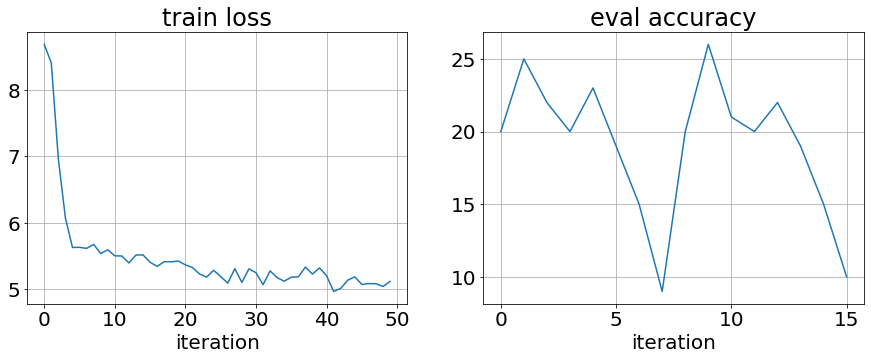

In [123]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)

So what is the attention layer learning?

It's learning to predict the alignment between words in the source and target sentences.

<center><img src="img/bahdanau2015.png", width="1000"></center>

These figures show the attention weights applied by a trained model to every word in the source sequence (English) when generating the shown target sequence (French).

We can see how the trained attention allows the decoder to look forward and back when generating the translation of "European Economic Area" (left pane) or "marine environment" (right pane).


**Image credits**

Some images in this tutorial were taken and/or adapted from:

- K. Xu et al. 2015, http://proceedings.mlr.press/v37/xuc15.html
- Sutskever et al. 2014, https://arxiv.org/abs/1409.3215
- Bahdanau et al. 2015, http://arxiv.org/abs/1409.0473
- Zhang et al., Dive into Deep Learning, 2019
- Peter Bloem, http://www.peterbloem.nl/blog/transformers
- Chris Olah, https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Ben Trevett, http://bentrevett.com